# Pre-Processing
## Business Problem
Leukemia is a type of cancer of the blood that often affects young people. In the past, pathologists would diagnose patients by eye after examining blood smear images under the microscope. But, this is time consuming and tedious. Advances in image recognition technology have come a long ways since their inception. Therefore, automated solutions using computers would be of great benefit to the medical community to aid in cancer diagnoses.

The goal of this project is to address the following question: How can the doctor’s at the Munich University Hospital automate the diagnosis of patients with leukemia using images from blood smears?

**Plan:**
1. Load annotations file.
2. Create features and labels.
3. Perform train-test split.
    1. Without stratify.
    2. With stratify.

In [1]:
import os
import pickle
import sys
sys.path.append('..')

import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split

from src import constants as con
from src.features import build_features as bf
from src.visualization import visualize as viz

# %load_ext autoreload
# %autoreload 2
%reload_ext autoreload
%matplotlib inline

## Load Annotations File
The annotations files contains the list of images, which will be used for the features, and list of morphologies, which are the labels.

In [2]:
df_annotate = pd.read_csv(os.path.join(con.REFERENCES_DIR, 'annotations.dat'), sep=' ', 
                          names=['Image Dir', 'Morphology', 'First Re-Annotation', 'Second Re-Annotation'])

In [3]:
df_annotate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18365 entries, 0 to 18364
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Image Dir             18365 non-null  object
 1   Morphology            18365 non-null  object
 2   First Re-Annotation   1905 non-null   object
 3   Second Re-Annotation  1905 non-null   object
dtypes: object(4)
memory usage: 574.0+ KB


## Features and Labels
Select the features and labels from the annotations file.

In [4]:
X = df_annotate['Image Dir'].values
y = df_annotate['Morphology'].values

Print out a few items in the features array. These are image file names.

In [5]:
X[:5]

array(['BAS/BAS_0001.tiff', 'BAS/BAS_0002.tiff', 'BAS/BAS_0003.tiff',
       'BAS/BAS_0004.tiff', 'BAS/BAS_0005.tiff'], dtype=object)

Print out of few of the label values. These are leukocite morphology types.

In [6]:
y[:5]

array(['BAS', 'BAS', 'BAS', 'BAS', 'BAS'], dtype=object)

## Flatten Images
Load each image and flatten into a one-dimensional array.
* Convert images to grayscale so they take up less memory on disk.

In [7]:
X_flat = bf.preprocess_images(X, flatten=True, gray=True, rescale=True, scale_factor=0.25)

Preprocessing Images:
 * Flattening.
 * Rescaling (25.00%).
 * Convert to grayscale.
It took 2.153 minutes to load and preprocess 18365 images.
The array of preprocessed images takes up 183.650 Mb of memory.


## Train-Test Split
Split the features and labels into training and test sets. I will set aside 20% of the dataset for testing and the rest for training.

First, let's examine the distribution in class counts for the labels.

In [8]:
print('Class fractions for the labels:')
pd.Series(y).value_counts(normalize=True)

Class fractions for the labels:


NGS    0.461966
LYT    0.214375
MYO    0.177947
MON    0.097414
EOS    0.023087
NGB    0.005935
BAS    0.004302
EBO    0.004247
PMO    0.003812
MYB    0.002287
MOB    0.001416
PMB    0.000980
KSC    0.000817
MMZ    0.000817
LYA    0.000599
dtype: float64

As pointed in the EDA step, there is a large difference in class counts for each of the morphological types.

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X_flat, y, test_size=0.2, random_state=42)

After splitting the data into train and test splits, how does the class distribution change?

In [10]:
print('Class fractions for labels in the training set:')
pd.Series(y_train).value_counts(normalize=True)

Class fractions for labels in the training set:


NGS    0.459978
LYT    0.215491
MYO    0.178260
MON    0.098013
EOS    0.023074
NGB    0.005990
BAS    0.004288
EBO    0.004084
PMO    0.003744
MYB    0.002110
MOB    0.001634
KSC    0.000953
PMB    0.000953
MMZ    0.000749
LYA    0.000681
dtype: float64

In [11]:
print('Class fractions for labels in the test set:')
pd.Series(y_test).value_counts(normalize=True)

Class fractions for labels in the test set:


NGS    0.469916
LYT    0.209910
MYO    0.176695
MON    0.095018
EOS    0.023142
NGB    0.005717
EBO    0.004901
BAS    0.004356
PMO    0.004084
MYB    0.002995
MMZ    0.001089
PMB    0.001089
MOB    0.000545
LYA    0.000272
KSC    0.000272
dtype: float64

To make the comparison clearer, let's compute the fractional difference in value counts between training and test labels. If the class distribution is the same between and train test sets, then the fractions should be close to 1.

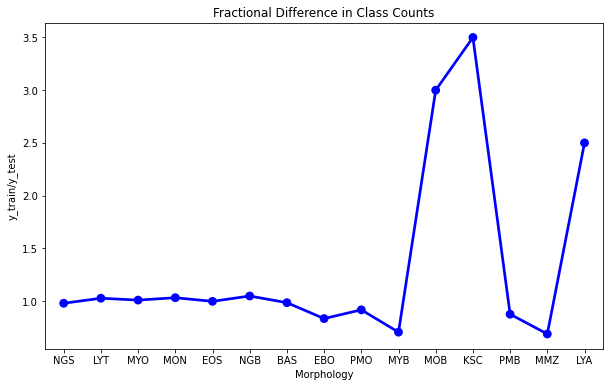

In [12]:
y_value_counts = viz.compare_class_spread(y_train, y_test)

In [13]:
y_value_counts

,Morphology,y_train,y_test,y_train/y_test
0,NGS,0.459978,0.469916,0.978853
1,LYT,0.215491,0.209910,1.026589
2,MYO,0.178260,0.176695,1.008860
3,MON,0.098013,0.095018,1.031519
4,EOS,0.023074,0.023142,0.997059
5,NGB,0.005990,0.005717,1.047619
6,BAS,0.004288,0.004356,0.984375
7,EBO,0.004084,0.004901,0.833333
8,PMO,0.003744,0.004084,0.916667
9,MYB,0.002110,0.002995,0.704545


In [14]:
print(f"Minimum fractional difference: {y_value_counts['y_train/y_test'].min():0.3f}")
print(f"Maximum fractional difference: {y_value_counts['y_train/y_test'].max():0.3f}")

Minimum fractional difference: 0.688
Maximum fractional difference: 3.500


As you can see, not all fractions are one. The lowest is around 0.69, while the higest is up to 3.5.

Let's redo the train/test split, but this time use the _`stratify`_ parameter to make the distribution in classes between the train and test sets more equal.

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X_flat, y, test_size=0.2, random_state=42, stratify=y)

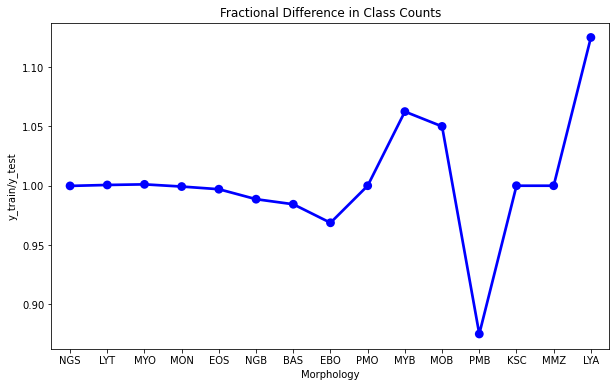

In [16]:
y_value_counts = viz.compare_class_spread(y_train, y_test)

In [17]:
y_value_counts

,Morphology,y_train,y_test,y_train/y_test
0,NGS,0.461952,0.462020,0.999853
1,LYT,0.214402,0.214266,1.000635
2,MYO,0.177988,0.177784,1.001149
3,MON,0.097400,0.097468,0.999302
4,EOS,0.023074,0.023142,0.997059
5,NGB,0.005922,0.005990,0.988636
6,BAS,0.004288,0.004356,0.984375
7,EBO,0.004220,0.004356,0.968750
8,PMO,0.003812,0.003812,1.000000
9,MYB,0.002314,0.002178,1.062500


In [18]:
print(f"Minimum fractional difference: {y_value_counts['y_train/y_test'].min():0.3f}")
print(f"Maximum fractional difference: {y_value_counts['y_train/y_test'].max():0.3f}")

Minimum fractional difference: 0.875
Maximum fractional difference: 1.125


The distribution in classes are now much closer to one.

## Save Train/Test Data
Save the training and test data to file. This data will not change during the modeling phase.

In [19]:
X_train.shape

(14692, 10000)

In [20]:
data_dict = {
    'X_train': X_train,
    'X_test': X_test,
    'y_train': y_train,
    'y_test': y_test
}

In [21]:
for key, value in data_dict.items():
    outfile = open(os.path.join(con.PROCESSED_DATA_DIR, key), 'wb')
    pickle.dump(value, outfile)
    outfile.close()